# Исследование сервиса аренды самокатов GoFast

<h3> Бриф <a class="tocSkip"></h2>

Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* **без подписки**
    * абонентская плата отсутствует;
    * стоимость одной минуты поездки — 8 рублей;
    * стоимость старта (начала поездки) — 50 рублей;
* **с подпиской Ultra** 
    * абонентская плата — 199 рублей в месяц;
    * стоимость одной минуты поездки — 6 рублей;
    * стоимость старта — бесплатно.

<h3> Цель исследования <a class="tocSkip"></h2>

Проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

<h3> План работы <a class="tocSkip"></h2>

1. Входные данные от сервиса **GoFast** — данные о некоторых пользователях из нескольких городов, а также об их поездках. Следует определить качество данных, соответственно первым шагом будет являться их **обзор**.
2. **Предобработка данных**
3. **Исследовательский анализ данных**, визуализация общей информации о пользователях и поездках, поиск зависимостей.
4. Изучения поведения пользователей с подпиской и бесплатным тарифом.
5. Расчет выручки
6. Проверка гипотез на основе входных данных
7. Общий вывод

### Обзор данных

In [1]:
# загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns

In [2]:
# чтение файлов
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subs = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
display(users.head(10))
display()
display(rides.head(10))
subs.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [4]:
print(users.info())
print()
print(rides.info())
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns

**Промежуточный вывод**

При осмотре данных были выявлены следующие моменты:
1. Ни в одной из таблиц не замечено явных пропусков: общее количество строк равно количеству записей в каждом столбце.
2. В столбце `'date'` датафрейма rides тип данных object, который следует поменять на datetime.

### Предобработка данных

In [5]:
# изменим тип данных object в datetime
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [6]:
# создадим новый столбец с номером месяца
rides['month'] = rides['date'].dt.month
rides.head(10)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


In [7]:
# чекаем
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [8]:
# проверка наличия пропусков
print(users.isna().sum())
rides.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [9]:
# проверка наличия дубликатов
print(users.duplicated().sum())
rides.duplicated().sum()

31


0

In [10]:
# удаление дубликатов
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

0

**Промежуточный вывод**

В ходе предобработки данных были выполнены следующие мероприятия:
1. Изменение типа данных в столбце `'date'`
2. Создания столбца в **rides** с месяцем поездки
3. Проверка наличия пропущенных значений и дубликатов в датафреймах **users** и **rides** и их обработка

### Исследовательский анализ данных

**частота встречаемости городов**

In [11]:
# создаем таблицу частот встречаемости городов
city_freq = users.pivot_table(index='city', values='user_id', aggfunc='count').sort_values('user_id')
city_freq.columns = ['freq']
city_freq

,freq
city,
Москва,168
Тюмень,180
Омск,183
Сочи,189
Краснодар,193
Ростов-на-Дону,198
Екатеринбург,204
Пятигорск,219


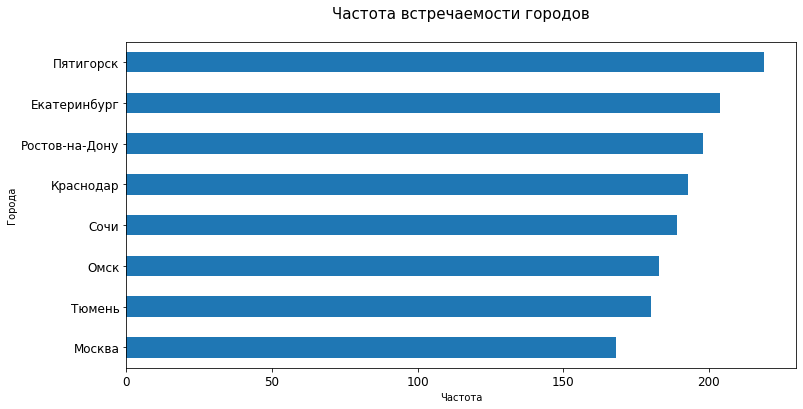

In [12]:
city_freq.plot(kind = 'barh', 
               figsize = (12,6), 
               legend = False, 
               fontsize = 12)

plt.title('Частота встречаемости городов' + "\n", fontsize=15)
plt.xlabel('Частота')
plt.ylabel('Города');

С помощью графика и сводной таблицы можно увидеть, что в рамках данной выборки пользователи из Пятигорска чаще всего пользуются услугами сервиса, в том время как москвичи находятся на последнем месте.

**соотношение пользователей с подпиской и без подписки**

In [13]:
subs_ratio = users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
subs_ratio.columns = ['count']
subs_ratio

,count
subscription_type,
free,835
ultra,699


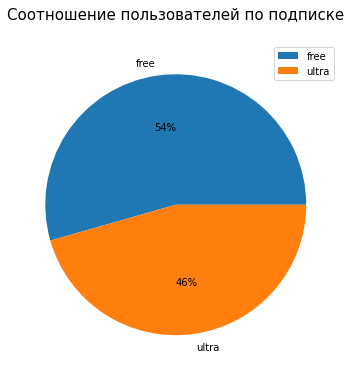

In [33]:
subs_ratio.plot(y='count', 
                kind='pie', 
                figsize=(12, 6),
                autopct='%1.0f%%')
plt.title('Соотношение пользователей по подписке' + "\n", fontsize=15)
plt.ylabel('');

Исходя из выборки, пользователи, пользующиеся подпиской, составляют 46%, а не платят за подписку примерно 54% людей.

**возраст пользователей**

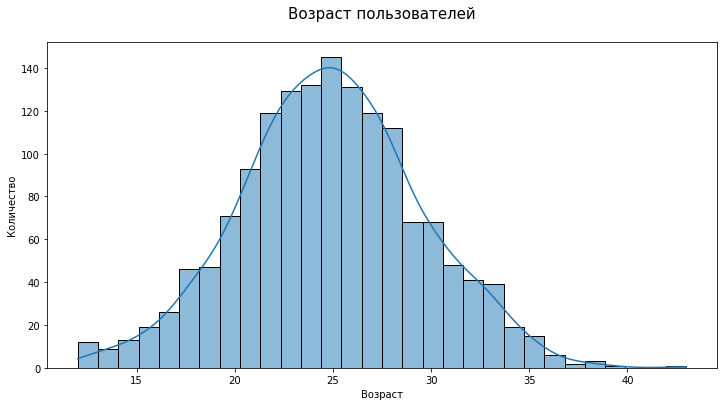

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(users['age'], kde=True)
plt.title('Возраст пользователей' + "\n", fontsize=15)
plt.xlabel('Возраст')
plt.ylabel('Количество');

Среднее выборочное значение равняется 25 годам. Распределение близко к нормальному.

**расстояние, которое пользователь преодолел за одну поездку**

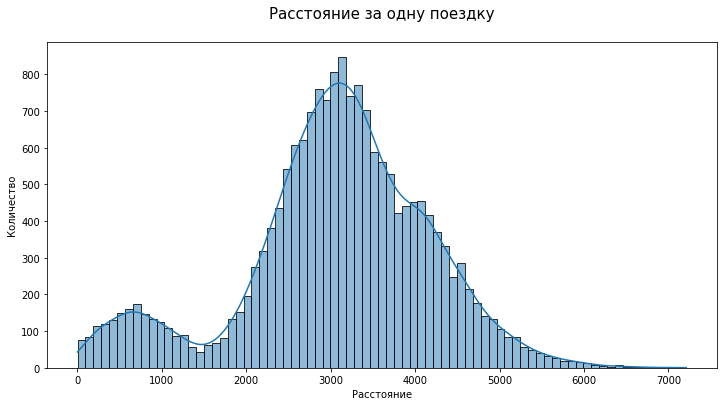

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(rides['distance'], kde=True)
plt.title('Расстояние за одну поездку' + "\n", fontsize=15)
plt.xlabel('Расстояние')
plt.ylabel('Количество');

In [17]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Медианна дистанции равна 3133 м, в то время как среднее значение 3070 м. 

Размах значений от почти 1 метра до 7.2 км. Пределы нормальных значений от 2.5 до 3.7 км. Также присутствует пик значений на 800 метрах, т.е. самокатами пользуются для преодоления не таких больших расстояний.

Значит в среднем пользователи сервиса проезжают за одну поездку на самокате 3 км.

**продолжительность поездок**

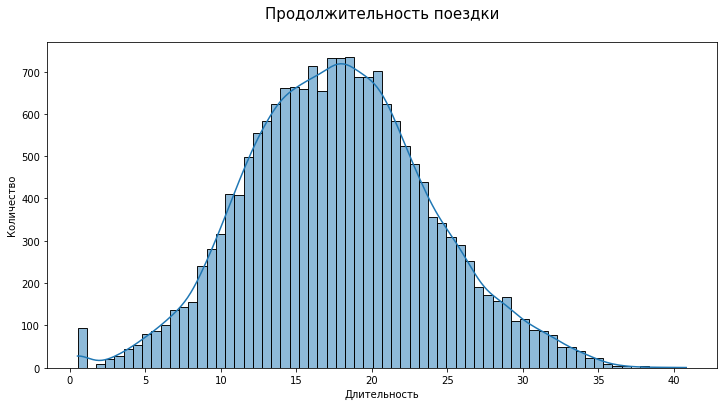

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(rides['duration'], kde=True)
plt.title('Продолжительность поездки' + "\n", fontsize=15)
plt.xlabel('Длительность')
plt.ylabel('Количество');

In [19]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Среднее выборочное значение длительности поездки равно 17 минутам. Размах значений от 5 секунд до 40 минут. Пределы же нормальных значений от 13 до 21 минуты.

На графике можно заметить скопление значений в районе нуля, что может говорить о том, что пользователи могли начать поездку и резко отменить возможно по техническим причинам.

**Промежуточный вывод**

1. Наибольшее количество пользователей находится в Пятигорске, наименьшее в Москве
2. Соотношение пользователей с подпиской и без подписки примерно 50/50, а точнее 46 на 54
3. Средний возраст пользователей колеблется от 20 до 30 лет
4. Среднее расстояние, преодолеваемое за одну поездку, равно 3070 м
5. Среднее время поездки равно 17 минутам

### Объединение данных

In [20]:
# объединение всех таблиц в один датафрейм
full_stat = users.merge(rides, on='user_id').merge(subs, on='subscription_type')
full_stat.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [21]:
# пользователи с подпиской 
ultra_sub = full_stat.query('subscription_type == "ultra"')
print(ultra_sub.shape)
ultra_sub.head()

(6500, 12)


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [22]:
# пользователи без подписки
free_sub = full_stat.query('subscription_type == "free"')
print(free_sub.shape)
free_sub.head()

(11568, 12)


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


**расстояние, которое пользователь преодолел за одну поездку**

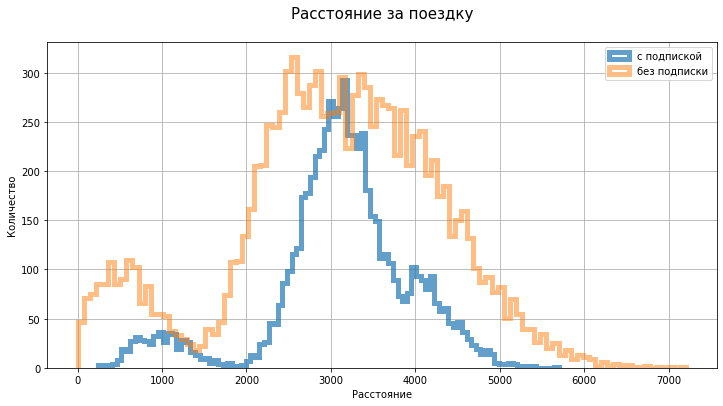

In [23]:
ax = ultra_sub.plot(
    kind='hist',
    y='distance',
    histtype='step',
    bins=100,
    linewidth=5,
    alpha=0.7,
    label='с подпиской',
)
free_sub.plot(
    kind='hist',
    y='distance',
    histtype='step',
    bins=100,
    linewidth=5,
    alpha=0.5,
    label='без подписки',
    ax=ax,
    grid=True,
    legend=True,
    figsize=(12,6)
)
plt.title('Расстояние за поездку' + "\n", fontsize=15)
plt.xlabel('Расстояние')
plt.ylabel('Количество');

Среднее значение в обеих группах совпадают, пик приходится на значения около 3 км. После 3.5 км у пользователей обеих категорий наблюдается тенденция снижения преодоленного расстояния.

На графике видно, что значения расстояния у пользователей без подписки обладают большим размахом: они проезжают как крайне малое расстояние (пик около нуля), так и достаточно длинные (график заканчивается на значении чуть больше 7 км), чем пользователи с подпиской.

**продолжительность поездок**

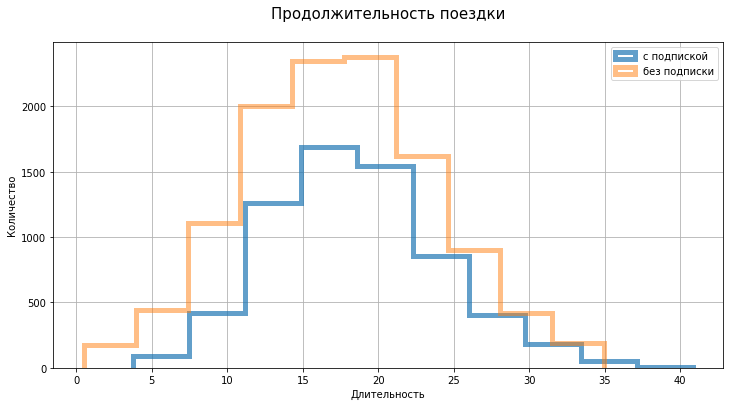

In [24]:
ax = ultra_sub.plot(
    kind='hist',
    y='duration',
    histtype='step',
    linewidth=5,
    alpha=0.7,
    label='с подпиской',
)
free_sub.plot(
    kind='hist',
    y='duration',
    histtype='step',
    linewidth=5,
    alpha=0.5,
    label='без подписки',
    ax=ax,
    grid=True,
    legend=True,
    figsize=(12,6)
)
plt.title('Продолжительность поездки' + "\n", fontsize=15)
plt.xlabel('Длительность')
plt.ylabel('Количество');

Можно сказать, что графики дублируют друг друга, однако различие в количестве людей: пользователей без подписки больше. Среднее значение колеблется в пределах 15-20 минут, после чего продолжительность поездки постепенно уменьшается. 

Кроме того, на графике видно, что пользователи с подпиской совершают поездки дольше другой группы примерно на 5 минут.

### Подсчёт выручки

In [25]:
# каждое значение из столбца duration округляется с помощью «потолка» 
full_stat['duration'] = np.ceil(full_stat['duration']).astype('int')

# создание агрегированного датафрейма
grouped_stat = full_stat[['user_id', 'distance', 'duration', 'month',
                          'minute_price', 'start_ride_price', 'subscription_fee']]
grouped_stat = (grouped_stat.groupby(['user_id', 'month'])
                .agg({'distance': 'sum',
                      'duration': 'sum',
                      'user_id': 'count',
                      'subscription_fee' : 'min',
                      'minute_price' : 'min',
                      'start_ride_price' : 'min'})
               )
grouped_stat = grouped_stat.rename(columns={'user_id': 'count'})
grouped_stat.head()

distance  duration  count  subscription_fee  minute_price  \
user_id month                                                                 
1       1      7027.511294        42      2               199             6   
        4       754.159807         7      1               199             6   
        8      6723.470560        46      2               199             6   
        10     5809.911100        32      2               199             6   
        11     7003.499363        56      3               199             6   

               start_ride_price  
user_id month                    
1       1                     0  
        4                     0  
        8                     0  
        10                    0  
        11                    0

In [26]:
# добавляем столбец с помесячной выручкой
grouped_stat['revenue'] = ((grouped_stat['start_ride_price'] * grouped_stat['count']) 
                           + (grouped_stat['minute_price'] * grouped_stat['duration']) + grouped_stat['subscription_fee'])
grouped_stat.head()

distance  duration  count  subscription_fee  minute_price  \
user_id month                                                                 
1       1      7027.511294        42      2               199             6   
        4       754.159807         7      1               199             6   
        8      6723.470560        46      2               199             6   
        10     5809.911100        32      2               199             6   
        11     7003.499363        56      3               199             6   

               start_ride_price  revenue  
user_id month                             
1       1                     0      451  
        4                     0      241  
        8                     0      475  
        10                    0      391  
        11                    0      535

### Проверка гипотез

Проверим некоторые гипотезы.
1. Тратят ли пользователи с подпиской больше времени на поездки?
2. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

##### 

**Важно понять, тратят ли пользователи с подпиской больше времени на поездки?** Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 

Проверим гипотезу, используя исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Пусть

H0: значения `duration` для пользователей обеих категорий равны

H1: `duration` пользователей с подпиской > `duration` пользователей с бесплатным тарифом

Уровень значимости возьмем 5%

In [28]:
ultra = ultra_sub['duration']
free = free_sub['duration']

alpha = .05

results = st.ttest_ind(ultra, 
                       free, 
                       alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки.

##### 

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. 

**Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?**

Проверим гипотезу, используя исходные данные о расстоянии, проезжаемом пользователями с подпиской.

Пусть

H0: значение `distance` для пользователей с подпиской = 3130

H1: подписчики в среднем проезжают расстояние больше оптимального. `distance` пользователей с подпиской > 3130

Уровень значимости возьмем 5%

In [29]:
ultra_dist = ultra_sub['distance']

interested_value = 3130

alpha = .05

results = st.ttest_1samp(ultra_dist, 
                         interested_value,
                         alternative='greater')
    
print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.9195368847849785
Не удалось отвергнуть нулевую гипотезу


Значение p-value больше заданного уровня значимости и составляет 91%, мы не можем отвергнуть нулевую гипотезу. Это значит, что подписчики проезжают расстояние, которое приводит к оптимальному износу.

##### 

**Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?**

Проверим гипотезу, используя исходные данные о помесячной выручке с каждого пользователя.

Пусть

H0: значение `revenue` для пользователей с подпиской = `revenue` для пользователей без подписки

H1: `revenue` пользователей с подпиской > `revenue` для пользователей без подписки

Уровень значимости возьмем 5%

In [30]:
ultra_month =  grouped_stat.loc[grouped_stat['subscription_fee'] == 199, 'revenue']
free_month = grouped_stat.loc[grouped_stat['subscription_fee'] == 0, 'revenue']


results = st.ttest_ind(ultra_month, 
                       free_month,
                       alternative = 'greater')

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, что позволяет утверждать, что выручка от подписчиков выше чем у пользователей с бесплатным тарифом.

##### 

### Общий вывод

Входные данные от сервиса аренды самокатов GoFast были обработаны и проанализированы.

В ходе работы были проведены следующие мероприятия и сделаны выводы:

**Предобработка данных:**
* Изменение типа данных в столбце 'date'
* Категоризация данных на основе столбца `date`
* Проверка наличия пропущенных значений и дубликатов в датафреймах и их обработка

**Исследовательский анализ данных**, который позволил глужбе изучить данные и вывести следующие инсайты:
* Наибольшее количество пользователей находится в Пятигорске, наименьшее в Москве
* Соотношение пользователей с подпиской и без подписки примерно 50/50, а точнее 46 на 54
* Средний возраст пользователей колеблется от 20 до 30 лет
* Среднее расстояние, преодолеваемое за одну поездку, равно 3070 м
* Среднее время поездки равно 17 минутам

**Поведение пользователей:**
* Пользователи с подпиской совершают поездки дольше другой группы примерно на 5 минут.
* Пользователи с бесплатным тарифом проезжают большие расстояние, чем подписчики сервиса

**Подсчет выручки**

Был добавлен столбец, отражающий помесячную выручку от каждого пользователя.

**Проверка гипотез**
* **Пользователи с подпиской тратят больше времени на поездки**

Есть основания говорить, что пользователи с подпиской тратят в сервисе больше денег.
* **Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров**

Подписчики проезжают расстояние, которое приводит к оптимальному износу.
* **Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки**

Помесячная выручка от подписчиков выше чем от пользователей с бесплатным тарифом.